In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import NearestNeighbors

In [30]:
plant=1
model="decisiontree"
partial_error=True
if ("autoencoder" in model)&(partial_error):
    print("warning! partial error is not implemented for autoencoder")

In [2]:
weather_data = pd.read_csv('../data/Plant_'+str(plant)+'_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../data/Plant_'+str(plant)+'_Generation_Data.csv')
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))

In [3]:
%matplotlib qt
if model=='linear':
    X = merged_df[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
    y = merged_df[['DC_POWER']]
    X_scaled = MinMaxScaler().fit_transform(X)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    merged_err=merged_df.join(pd.DataFrame(y_pred), rsuffix="_pred")
    merged_err.rename(columns={0: 'DC_POWER_pred'}, inplace=True)
    merged_err['ERROR']=(merged_err['DC_POWER']-merged_err['DC_POWER_pred'])**2
    plt.plot(y,  'r.', alpha=0.6,label='real')
    plt.plot(y_pred, label='predicted')
    plt.title('predicted vs. real DC power of train data')
    plt.legend()
elif model=='decisiontree':
    X = merged_df[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
    y = merged_df[['DC_POWER']]
    X_scaled = MinMaxScaler().fit_transform(X)
    reg = DecisionTreeRegressor().fit(X, y)
    y_pred = reg.predict(X)
    merged_err=merged_df.join(pd.DataFrame(y_pred), rsuffix="_pred")
    merged_err.rename(columns={0: 'DC_POWER_pred'}, inplace=True)
    merged_err['ERROR']=(merged_err['DC_POWER']-merged_err['DC_POWER_pred'])**2
    plt.plot(y,  'r.', alpha=0.6,label='real')
    plt.plot(y_pred, label='predicted')
    plt.title('predicted vs. real DC power of train data')
    plt.legend()
elif model=='autoencodersimple':
    X= merged_df[['DC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
    X_scaled = MinMaxScaler().fit_transform(X)
    input_layer = Input(shape =(X.shape[1], ))
    encoded = Dense(3, activation ='tanh', activity_regularizer = regularizers.l1(10e-5))(input_layer)
    output_layer = Dense(X.shape[1], activation ='sigmoid')(encoded)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer ="adam", loss ="mse")
    History=autoencoder.fit(X_scaled, X_scaled,batch_size = 100, epochs = 50,shuffle = True, validation_split = 0.10)
    encoded_train_data=autoencoder.predict(X_scaled)
    scaled_train_features = pd.DataFrame(encoded_train_data, index=X.index, columns=X.columns)
    X_scaled_df=pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    train_mae_loss = np.mean((X_scaled_df - scaled_train_features)**2, axis=1)
    merged_err=merged_df.join(pd.DataFrame(train_mae_loss))
    merged_err.rename(columns={0: 'ERROR'}, inplace=True)
    plt.plot(X_scaled_df.DC_POWER,  'r.', alpha=0.6,label='real')
    plt.plot(scaled_train_features.DC_POWER, label='predicted')
    plt.title('predicted vs. real DC power of train data')
    plt.legend()
elif model=='autoencodermedium':
    X= merged_df[['DC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
    X_scaled = MinMaxScaler().fit_transform(X)
    input_layer = Input(shape =(X.shape[1], ))
    encoded = Dense(6, activation ='relu',activity_regularizer = regularizers.l1(10e-5))(input_layer)
    encoded = Dense(3, activation ='relu',activity_regularizer = regularizers.l1(10e-5))(encoded)
    output_layer = Dense(X.shape[1], activation ='sigmoid')(encoded)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer ="adam", loss ="mse")
    History=autoencoder.fit(X_scaled, X_scaled,batch_size = 100, epochs = 40,shuffle = True, validation_split = 0.10)
    encoded_train_data=autoencoder.predict(X_scaled)
    scaled_train_features = pd.DataFrame(encoded_train_data, index=X.index, columns=X.columns)
    X_scaled_df=pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    train_mae_loss = np.mean((X_scaled_df - scaled_train_features)**2, axis=1)
    merged_err=merged_df.join(pd.DataFrame(train_mae_loss))
    merged_err.rename(columns={0: 'ERROR'}, inplace=True)
    plt.plot(X_scaled_df.DC_POWER,  'r.', alpha=0.6,label='real')
    plt.plot(scaled_train_features.DC_POWER, label='predicted')
    plt.title('predicted vs. real DC power of train data')
    plt.legend()
if partial_error:
    merged_err.loc[merged_err['DC_POWER']>merged_err['DC_POWER_pred'], 'ERROR']=0

In [4]:
merged_err.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR,DC_POWER_pred,ERROR
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.0,0.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.0,0.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.0,0.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.0,0.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.0,0.0


In [6]:
def get_outliers_for_fit(data, x_column, y_column, groupby_column, output_column_name=False, window=False, outlier_limit=3):
    if output_column_name==False:
        output_column_name=column+"_outliers"
    data[output_column_name]=0
    data['gross_efficiency']=data[y_column]/data[x_column]
    for i, group in  data.groupby(groupby_column):
        resorted=group.reset_index().set_index('DATE_TIME').copy()
        outlier_condition1=resorted[resorted[y_column]>0]['gross_efficiency']>(resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).mean() + (outlier_limit+1)*resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).std())
        outlier_condition2=resorted[resorted[y_column]>0]['gross_efficiency']<(resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).mean() - outlier_limit*resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).std())            
        outlier_condition3=resorted[resorted[y_column]>0][x_column]>0.1*resorted[resorted[y_column]>0][x_column].rolling(window=window).max()
        data.loc[resorted[resorted[y_column]>0][(outlier_condition1|outlier_condition2)&outlier_condition3]['index'], output_column_name]=1
        data.loc[resorted[(resorted[y_column]==0)&(resorted[x_column]>0.1*resorted[x_column].rolling(window=window).max())]['index'], output_column_name]=1
    return data
def get_outlier_errors(data, column, groupby_column, output_column_name=False, outlier_limit=3, window='7d'):
    #cleaned_column='cleaned'
    if output_column_name==False:
        output_column_name=column+"_outliers"
    data[output_column_name]=0
    resorted=data.reset_index().set_index('DATE_TIME').copy()
    outlier_condition1=resorted[resorted[column]>0][column]>(resorted[resorted[column]>0][column].rolling(window=window).mean() + (outlier_limit)*resorted[resorted[column]>0][column].rolling(window=window).std())
    data.loc[resorted[resorted[column]>0][outlier_condition1]['index'], output_column_name]=1
    return data

In [7]:
merged_outliers=get_outlier_errors(merged_err, 'ERROR', 'SOURCE_KEY', output_column_name="alarm_DC_conversion_outlier", window='7d', outlier_limit=8)
merged_dc_outlier=get_outliers_for_fit(merged_outliers.copy(), 'IRRADIATION', 'DC_POWER', 'SOURCE_KEY', output_column_name="alarm_DC_conversion_outlier_targ", window='7d', outlier_limit=4)

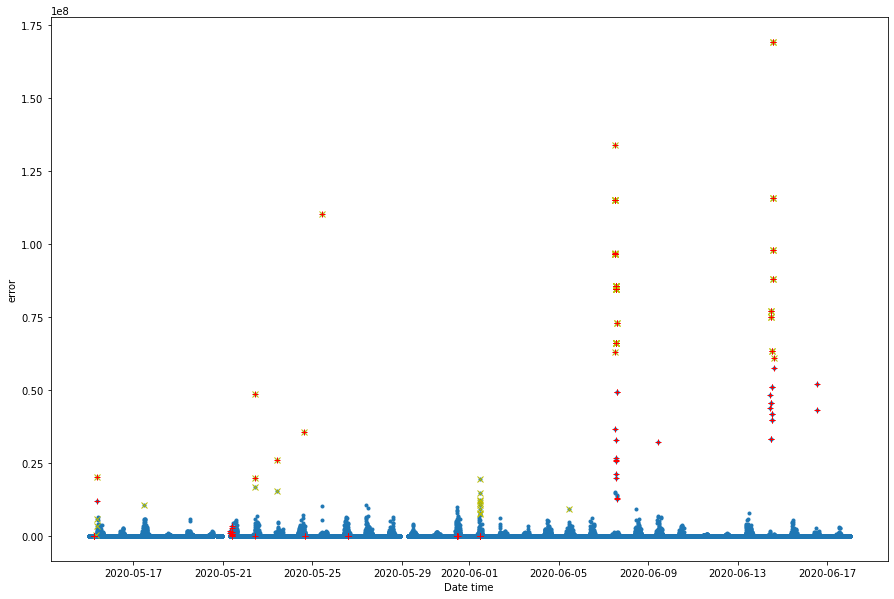

In [8]:
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.plot(merged_dc_outlier['DATE_TIME'], merged_dc_outlier['ERROR'], '.')
plt.plot(merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier"]==1]['DATE_TIME'], 
         merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier"]==1]['ERROR'], 'yx')
plt.plot(merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier_targ"]==1]['DATE_TIME'], 
         merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier_targ"]==1]['ERROR'], 'r+')
#plt.plot(merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['DATE_TIME'], 
#         merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['ERROR'], 'gx')
plt.xlabel('Date time')
plt.ylabel('error')
plt.show()

## 2. Inverter level efficiency

#### Calculate a mean reconstruction error per inverter per day and then compare those mean values to find inverters with higher mean reconstruction error in a single day and then over several days.

In [14]:
def daily_inverter_error(data, column, groupby_column):
    return pd.DataFrame(data.groupby(groupby_column)[column].mean()).reset_index()

In [15]:
daily_inv_error_df=daily_inverter_error(merged_outliers[merged_outliers.alarm_DC_conversion_outlier == 0], 'ERROR', ['SOURCE_KEY', 'DAY'])
daily_inv_error_df.head()

,SOURCE_KEY,DAY,ERROR
0,1BY6WEcLGh8j5v7,136,270139.167191
1,1BY6WEcLGh8j5v7,137,48560.442569
2,1BY6WEcLGh8j5v7,138,269571.209204
3,1BY6WEcLGh8j5v7,139,73352.106008
4,1BY6WEcLGh8j5v7,140,121616.274972
...,...,...,...
743,zVJPv84UY57bAof,165,87223.331208
744,zVJPv84UY57bAof,166,9113.392341
745,zVJPv84UY57bAof,167,25638.520415
746,zVJPv84UY57bAof,168,4982.430872


In [18]:
daily_inv_error_df['norm_error']=daily_inv_error_df['ERROR']/daily_inv_error_df['ERROR'].max()
daily_inv_error_df

,SOURCE_KEY,DAY,ERROR,norm_error
0,1BY6WEcLGh8j5v7,136,270139.167191,0.075446
1,1BY6WEcLGh8j5v7,137,48560.442569,0.013562
2,1BY6WEcLGh8j5v7,138,269571.209204,0.075288
3,1BY6WEcLGh8j5v7,139,73352.106008,0.020486
4,1BY6WEcLGh8j5v7,140,121616.274972,0.033966
...,...,...,...,...
743,zVJPv84UY57bAof,165,87223.331208,0.024360
744,zVJPv84UY57bAof,166,9113.392341,0.002545
745,zVJPv84UY57bAof,167,25638.520415,0.007161
746,zVJPv84UY57bAof,168,4982.430872,0.001392


In [19]:
def find_cloudiness_v2(data, col_name, neighbour_number=10, outlier_limit=10):
    #Removing outliers from the max curve
    clean_data=data.copy()
    X=clean_data[['TIME', col_name]]
    nbrs = NearestNeighbors(n_neighbors=neighbour_number).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distance=pd.DataFrame(distances).loc[:, 1:].mean(axis=1)
    outlier_condition=distance>distance.mean()+outlier_limit*distance.std()
    clean_data.drop(distance[outlier_condition].index, inplace=True)
    agg_h_irr_clean = clean_data.groupby(clean_data.TIME).agg({col_name: 'max'})
    weather_maxirr = pd.merge(data, agg_h_irr_clean, how='inner', on='TIME', suffixes=('', '_max'))
    weather_maxirr['offset_from_max']=(weather_maxirr[col_name+'_max']-weather_maxirr[col_name])**2
    C_day_list=weather_maxirr.groupby('DAY').sum()['offset_from_max']
    output=pd.DataFrame(C_day_list)
    output.columns=['cloudiness']
    output.reset_index(inplace=True)
    return output
def negative_trend_by_days(data, column, cloudiness, output_column_name, window=10, limit=-0.75):
    """
    Given a dataframe of inverter daily efficiencies calculates negative trends over a window of days. 
    Returns the dataframe with a new column, with 1 where the negative trend is below a certain limit.
    """
    data=data.merge(cloudiness, on='DAY')
    data['efficiency_trend']=0
    data['weather_trend']=0
    data[output_column_name]=0
    for inv in data.SOURCE_KEY.unique():
        data.loc[data.SOURCE_KEY==inv, 'efficiency_trend']=(data[data.SOURCE_KEY==inv]['DAY']/data[data.SOURCE_KEY==inv]['DAY'].max()).rolling(window=window).corr(data[data.SOURCE_KEY==inv][column]/data[data.SOURCE_KEY==inv][column].max())
        #data.loc[data.SOURCE_KEY==inv, 'weather_trend']=(data[data.SOURCE_KEY==inv][column]/data[data.SOURCE_KEY==inv][column].max()).rolling(window=window).corr(data[data.SOURCE_KEY==inv]['cloudiness']/data[data.SOURCE_KEY==inv]['cloudiness'].max())
    data.loc[(data['efficiency_trend']>=limit), output_column_name]=1
    ####
    return data.drop(columns=['efficiency_trend', 'weather_trend', 'cloudiness'])

In [20]:
cloudiness_v2=find_cloudiness_v2(weather_data, 'IRRADIATION')
daily_inv_error_df=negative_trend_by_days(daily_inv_error_df, 'norm_error', cloudiness_v2, output_column_name='alarm_negative_trend', window=10, limit=0.8)

No handles with labels found to put in legend.


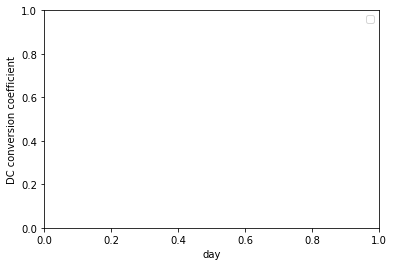

In [21]:
data=daily_inv_error_df
data[data['alarm_negative_trend']==1]
for inv in data[data['alarm_negative_trend']==1].SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['norm_error']/data[data.SOURCE_KEY==inv]['norm_error'].max(), '.', label=inv)
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')
plt.legend()

In [22]:
def efficiency_drop_by_day(data, column, outlier_coeff, drop_column_name, jump_column_name, window=20):
    """
    Given a dataframe of inverter daily efficiencies calculates efficiency jumps and falls relative to inverter history.
    """
    if drop_column_name:
        data[drop_column_name]=0
    if jump_column_name:
        data[jump_column_name]=0
    data['efficiency_lower_limit']=0
    data['efficiency_higher_limit']=0
    if window:
        for inv in data.SOURCE_KEY.unique():
            data.loc[data.SOURCE_KEY==inv, 'efficiency_lower_limit']=data[data.SOURCE_KEY==inv][column].rolling(window=window).median()-outlier_coeff*data[data.SOURCE_KEY==inv][column].rolling(window=window).std()
            data.loc[data.SOURCE_KEY==inv, 'efficiency_higher_limit']=data[data.SOURCE_KEY==inv][column].rolling(window=window).median()+outlier_coeff*data[data.SOURCE_KEY==inv][column].rolling(window=window).std()
    else:
        for inv in data.SOURCE_KEY.unique():
            data.loc[data.SOURCE_KEY==inv, 'efficiency_lower_limit']=data[data.SOURCE_KEY==inv][column].median()-outlier_coeff*data[data.SOURCE_KEY==inv][column].std()
            data.loc[data.SOURCE_KEY==inv, 'efficiency_higher_limit']=data[data.SOURCE_KEY==inv][column].median()+outlier_coeff*data[data.SOURCE_KEY==inv][column].std()
    if drop_column_name:
        data.loc[data[column]>data['efficiency_higher_limit'], drop_column_name]=1
    if jump_column_name:
        data.loc[data[column]<data['efficiency_lower_limit'], jump_column_name]=1
    return data.drop(columns=['efficiency_lower_limit', 'efficiency_higher_limit'])

Text(0, 0.5, 'DC conversion coefficient')

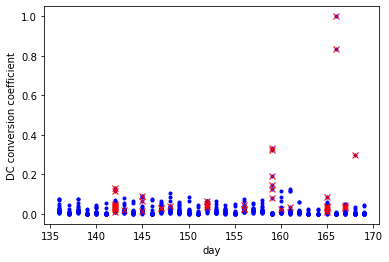

In [23]:
daily_inv_error_df=efficiency_drop_by_day(daily_inv_error_df, 'norm_error', 2, 'alarm_DC_conversion_fall', 'alarm_DC_conversion_jump', window=7)
inverters=daily_inv_error_df[daily_inv_error_df['alarm_DC_conversion_fall']==1]['SOURCE_KEY'].unique()
data=daily_inv_error_df[daily_inv_error_df['SOURCE_KEY'].isin(inverters)]
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['norm_error'], 'b.')
plt.plot(data[data.alarm_DC_conversion_fall==1]['DAY'], data[data.alarm_DC_conversion_fall==1]['norm_error'], 'rx')
#plt.plot(data[data.alarm_DC_conversion_jump==1]['DAY'], data[data.alarm_DC_conversion_jump==1]['DC_efficiency'], 'gx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

In [24]:
def get_inefficient_inverters_day(data, column, output_column_name, anomaly_limit = 2):
    data[output_column_name] = 0
    for _,d in data.groupby('DAY'):
        col_mean = d[column].mean()
        col_std = d[column].std()
        data.loc[d[(d[column] > col_mean + anomaly_limit * col_std)].index,output_column_name] = 1
    return data
def get_inefficient_inverters_window(data, column, output_column_name, window=7):
    data[output_column_name] = 0
    for inv in data['SOURCE_KEY'].unique():
        data.loc[data['SOURCE_KEY']==inv, output_column_name]=data[data['SOURCE_KEY']==inv][column].rolling(window = window).min()
    return data

Text(0, 0.5, 'DC conversion coefficient')

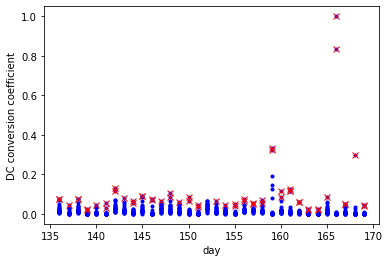

In [25]:
daily_inv_error_df = get_inefficient_inverters_day(daily_inv_error_df, 'norm_error', 'alarm_inefficient_inverter_day', anomaly_limit=2)
data=daily_inv_error_df
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['norm_error'], 'b.')
plt.plot(data[data.alarm_inefficient_inverter_day==1]['DAY'], data[data.alarm_inefficient_inverter_day==1]['norm_error'], 'rx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

Text(0, 0.5, 'DC conversion coefficient')

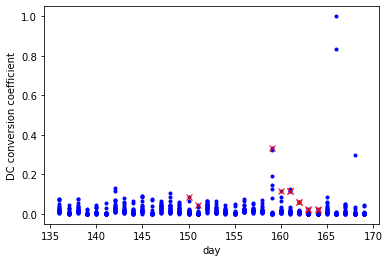

In [27]:
daily_inv_error_df = get_inefficient_inverters_window(daily_inv_error_df, 'alarm_inefficient_inverter_day', 'alarm_inefficient_inverter_window', window=7)
data=daily_inv_error_df
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['norm_error'], 'b.')
plt.plot(data[data.alarm_inefficient_inverter_window==1]['DAY'], data[data.alarm_inefficient_inverter_window==1]['norm_error'], 'rx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

In [29]:
if partial_error:
    model_detail="partial_error"
else:
    model_detail=""
merged_outliers.to_csv('../data/processed_data/Plant_'+str(plant)+'_'+model+model_detail+'_alarm_data.csv')
daily_inv_error_df.to_csv('../data/processed_data/Plant_'+str(plant)+'_'+model+model_detail+'_efficiency_alarm_data.csv')